# Examples of creating and operating distributions in Pixyz

In [1]:
from __future__ import print_function
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

torch.manual_seed(1)

In [2]:
from pixyz.distributions import Normal
from pixyz.utils import print_latex

In [3]:
x_dim = 20
y_dim = 30
z_dim = 40
a_dim = 50
batch_n = 2

class P1(Normal):
    def __init__(self):
        super(P1, self).__init__(var=["x"], cond_var=["y", "a"], name="p_{1}")

        self.fc1 = nn.Linear(y_dim, 10)
        self.fc2 = nn.Linear(a_dim, 10)
        self.fc21 = nn.Linear(10+10, 20)
        self.fc22 = nn.Linear(10+10, 20)

    def forward(self, a, y):
        h1 = F.relu(self.fc1(y))
        h2 = F.relu(self.fc2(a))
        h12 = torch.cat([h1, h2], 1)
        return {"loc": self.fc21(h12), "scale": F.softplus(self.fc22(h12))}

class P2(Normal):
    def __init__(self):
        super(P2, self).__init__(var=["z"], cond_var=["x", "y"], name="p_{2}")

        self.fc3 = nn.Linear(x_dim, 30)
        self.fc4 = nn.Linear(30+y_dim, 400)
        self.fc51 = nn.Linear(400, 20)
        self.fc52 = nn.Linear(400, 20)

    def forward(self, x, y):
        h3 = F.relu(self.fc3(x))
        h4 = F.relu(self.fc4(torch.cat([h3, y], 1)))
        return {"loc": self.fc51(h4), "scale": F.softplus(self.fc52(h4))}
    
p4 = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.), var=["a"], features_shape=[a_dim], name="p_{4}")
p6 = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.), var=["y"], features_shape=[y_dim], name="p_{6}")
    
x = torch.from_numpy(np.random.random((batch_n, x_dim)).astype("float32"))
y = torch.from_numpy(np.random.random((batch_n, y_dim)).astype("float32"))
a = torch.from_numpy(np.random.random((batch_n, a_dim)).astype("float32"))

In [4]:
p1 = P1()
p2 = P2()
p3 = p2 * p1
p3.name = "p_{3}"
p5 = p3 * p4
p5.name = "p_{5}"
p_all = p1*p2*p4*p6
p_all.name = "p_{all}"

In [5]:
print(p1)
print_latex(p1)

Distribution:
  p_{1}(x|y,a)
Network architecture:
  P1(
    name=p_{1}, distribution_name=Normal,
    var=['x'], cond_var=['y', 'a'], input_var=['y', 'a'], features_shape=torch.Size([])
    (fc1): Linear(in_features=30, out_features=10, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
    (fc21): Linear(in_features=20, out_features=20, bias=True)
    (fc22): Linear(in_features=20, out_features=20, bias=True)
  )


<IPython.core.display.Math object>

In [6]:
print(p2)
print_latex(p2)

Distribution:
  p_{2}(z|x,y)
Network architecture:
  P2(
    name=p_{2}, distribution_name=Normal,
    var=['z'], cond_var=['x', 'y'], input_var=['x', 'y'], features_shape=torch.Size([])
    (fc3): Linear(in_features=20, out_features=30, bias=True)
    (fc4): Linear(in_features=60, out_features=400, bias=True)
    (fc51): Linear(in_features=400, out_features=20, bias=True)
    (fc52): Linear(in_features=400, out_features=20, bias=True)
  )


<IPython.core.display.Math object>

In [7]:
print(p3)
print_latex(p3)

Distribution:
  p_{3}(z,x|y,a) = p_{2}(z|x,y)p_{1}(x|y,a)
Network architecture:
  P1(
    name=p_{1}, distribution_name=Normal,
    var=['x'], cond_var=['y', 'a'], input_var=['y', 'a'], features_shape=torch.Size([])
    (fc1): Linear(in_features=30, out_features=10, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
    (fc21): Linear(in_features=20, out_features=20, bias=True)
    (fc22): Linear(in_features=20, out_features=20, bias=True)
  )
  P2(
    name=p_{2}, distribution_name=Normal,
    var=['z'], cond_var=['x', 'y'], input_var=['x', 'y'], features_shape=torch.Size([])
    (fc3): Linear(in_features=20, out_features=30, bias=True)
    (fc4): Linear(in_features=60, out_features=400, bias=True)
    (fc51): Linear(in_features=400, out_features=20, bias=True)
    (fc52): Linear(in_features=400, out_features=20, bias=True)
  )


<IPython.core.display.Math object>

In [8]:
print(p4)
print_latex(p4)

Distribution:
  p_{4}(a)
Network architecture:
  Normal(
    name=p_{4}, distribution_name=Normal,
    var=['a'], cond_var=[], input_var=[], features_shape=torch.Size([50])
    (loc): torch.Size([1, 50])
    (scale): torch.Size([1, 50])
  )


<IPython.core.display.Math object>

In [9]:
print(p5)
print_latex(p5)

Distribution:
  p_{5}(z,x,a|y) = p_{2}(z|x,y)p_{1}(x|y,a)p_{4}(a)
Network architecture:
  Normal(
    name=p_{4}, distribution_name=Normal,
    var=['a'], cond_var=[], input_var=[], features_shape=torch.Size([50])
    (loc): torch.Size([1, 50])
    (scale): torch.Size([1, 50])
  )
  P1(
    name=p_{1}, distribution_name=Normal,
    var=['x'], cond_var=['y', 'a'], input_var=['y', 'a'], features_shape=torch.Size([])
    (fc1): Linear(in_features=30, out_features=10, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
    (fc21): Linear(in_features=20, out_features=20, bias=True)
    (fc22): Linear(in_features=20, out_features=20, bias=True)
  )
  P2(
    name=p_{2}, distribution_name=Normal,
    var=['z'], cond_var=['x', 'y'], input_var=['x', 'y'], features_shape=torch.Size([])
    (fc3): Linear(in_features=20, out_features=30, bias=True)
    (fc4): Linear(in_features=60, out_features=400, bias=True)
    (fc51): Linear(in_features=400, out_features=20, bias=True)
   

<IPython.core.display.Math object>

In [10]:
print(p_all)
print_latex(p_all)

Distribution:
  p_{all}(z,x,a,y) = p_{2}(z|x,y)p_{1}(x|y,a)p_{4}(a)p_{6}(y)
Network architecture:
  Normal(
    name=p_{6}, distribution_name=Normal,
    var=['y'], cond_var=[], input_var=[], features_shape=torch.Size([30])
    (loc): torch.Size([1, 30])
    (scale): torch.Size([1, 30])
  )
  Normal(
    name=p_{4}, distribution_name=Normal,
    var=['a'], cond_var=[], input_var=[], features_shape=torch.Size([50])
    (loc): torch.Size([1, 50])
    (scale): torch.Size([1, 50])
  )
  P1(
    name=p_{1}, distribution_name=Normal,
    var=['x'], cond_var=['y', 'a'], input_var=['y', 'a'], features_shape=torch.Size([])
    (fc1): Linear(in_features=30, out_features=10, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
    (fc21): Linear(in_features=20, out_features=20, bias=True)
    (fc22): Linear(in_features=20, out_features=20, bias=True)
  )
  P2(
    name=p_{2}, distribution_name=Normal,
    var=['z'], cond_var=['x', 'y'], input_var=['x', 'y'], features_shape=tor

<IPython.core.display.Math object>

In [11]:
for param in p3.parameters():
     print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([10, 30])
<class 'torch.Tensor'> torch.Size([10])
<class 'torch.Tensor'> torch.Size([10, 50])
<class 'torch.Tensor'> torch.Size([10])
<class 'torch.Tensor'> torch.Size([20, 20])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([20, 20])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([30, 20])
<class 'torch.Tensor'> torch.Size([30])
<class 'torch.Tensor'> torch.Size([400, 60])
<class 'torch.Tensor'> torch.Size([400])
<class 'torch.Tensor'> torch.Size([20, 400])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([20, 400])
<class 'torch.Tensor'> torch.Size([20])


In [12]:
p1.sample({"a":a, "y":y}, return_all=False)

{'x': tensor([[-1.1080, -1.1448,  0.3645,  0.8265, -0.0342,  0.3246,  1.2158, -0.7814,
           0.4136,  0.1797, -0.7113, -0.6147,  0.6630, -1.2774, -1.8449, -0.8617,
           0.6214,  0.2736,  0.2798, -0.0211],
         [-0.2552, -0.6734, -0.0462,  2.1422,  0.8061,  0.6504, -0.9144,  0.3330,
          -0.6654,  1.8404,  0.4712, -0.1908, -0.6778,  0.7943,  0.8817,  1.1594,
           0.3425, -0.7468,  0.2854,  0.3387]])}

In [13]:
p1.sample({"a":a, "y":y}, sample_shape=[5], return_all=False)

{'x': tensor([[[ 0.2361,  0.4032,  0.0695, -0.5533,  1.4330, -1.2905,  0.9687,
           -0.0577,  1.1533, -0.5694,  1.0572,  0.6492, -0.0456, -0.4337,
            1.4848,  0.2504,  1.4454, -0.7443,  0.8191, -0.9356],
          [ 2.2134,  0.0875, -0.4107,  0.4107,  0.4590,  0.9196,  0.5432,
           -0.6694,  0.1509, -0.9104, -0.0669,  0.9513,  0.9181, -0.3561,
            1.1535, -1.4426,  1.5048, -1.1466, -0.4321,  0.4410]],
 
         [[ 0.4027,  0.5023,  1.1012,  0.0531, -0.0900,  0.3504,  0.0224,
           -1.0426,  0.4490, -0.7878, -0.0834,  0.2744,  0.5666, -0.6071,
            0.5528,  0.6068,  2.3289, -0.1833,  1.1016,  0.2819],
          [-0.3916, -1.8881,  1.1777,  0.1526,  0.3053,  0.1854,  0.4316,
           -1.7862,  0.2638,  0.0908, -0.7300,  0.1897, -1.0572, -0.4123,
            0.6058,  1.0998, -1.3688,  0.2041,  0.6267,  0.4025]],
 
         [[-0.3304,  0.0434,  0.6254, -0.2385,  0.0669, -1.3313,  0.1627,
            1.0354,  1.1990,  0.9442, -0.4519,  1.3349, -0.

In [14]:
p1.sample({"a":a, "y":y}, return_all=True)

{'a': tensor([[0.1320, 0.0491, 0.7590, 0.5842, 0.3375, 0.9551, 0.8056, 0.2712, 0.9071,
          0.5097, 0.0261, 0.8238, 0.0823, 0.6461, 0.4548, 0.2272, 0.6942, 0.6650,
          0.5703, 0.9859, 0.6487, 0.8432, 0.5360, 0.2182, 0.4599, 0.0878, 0.4800,
          0.6572, 0.4341, 0.8360, 0.2246, 0.3745, 0.1591, 0.8631, 0.6649, 0.9799,
          0.5513, 0.3578, 0.1858, 0.3634, 0.8616, 0.1546, 0.3706, 0.5987, 0.9042,
          0.0458, 0.6299, 0.5196, 0.9889, 0.2224],
         [0.3299, 0.7013, 0.2179, 0.1459, 0.1066, 0.8810, 0.7327, 0.2921, 0.3975,
          0.3387, 0.7939, 0.2516, 0.2301, 0.2209, 0.8894, 0.1208, 0.5188, 0.4123,
          0.5215, 0.7918, 0.9131, 0.5561, 0.5978, 0.3926, 0.9542, 0.3080, 0.0552,
          0.7052, 0.2928, 0.5813, 0.5792, 0.9748, 0.1479, 0.6273, 0.0294, 0.7211,
          0.7053, 0.6399, 0.3759, 0.6624, 0.8164, 0.8344, 0.3406, 0.6040, 0.2594,
          0.5917, 0.5722, 0.7041, 0.2925, 0.1478]]),
 'y': tensor([[0.5370, 0.9887, 0.4120, 0.4911, 0.6232, 0.3370, 0.7106, 

In [15]:
p1_log_prob = p1.log_prob()
print(p1_log_prob)
print_latex(p1_log_prob)

\log p_{1}(x|y,a)


<IPython.core.display.Math object>

In [16]:
outputs = p1.sample({"y": y, "a": a})
print(p1_log_prob.eval(outputs))

tensor([-25.0060, -26.2503], grad_fn=<SumBackward2>)


In [17]:
outputs = p2.sample({"x":x, "y":y})
print(p2.log_prob().eval(outputs))

tensor([-24.9541, -24.4006], grad_fn=<SumBackward2>)


In [18]:
outputs = p1.sample({"y": y, "a": a})
print(outputs)

{'y': tensor([[0.5370, 0.9887, 0.4120, 0.4911, 0.6232, 0.3370, 0.7106, 0.6299, 0.5968,
         0.6134, 0.2168, 0.6809, 0.6891, 0.6831, 0.1974, 0.1279, 0.3578, 0.0317,
         0.5218, 0.0989, 0.5027, 0.9794, 0.6124, 0.7499, 0.0116, 0.1185, 0.5691,
         0.7956, 0.5116, 0.0600],
        [0.6602, 0.8747, 0.5161, 0.3215, 0.6065, 0.4116, 0.3064, 0.7506, 0.1647,
         0.5874, 0.4610, 0.4767, 0.7404, 0.3111, 0.4335, 0.8460, 0.1291, 0.8882,
         0.8390, 0.8023, 0.4412, 0.6205, 0.4831, 0.3605, 0.8874, 0.6466, 0.2698,
         0.2137, 0.8227, 0.6566]]), 'a': tensor([[0.1320, 0.0491, 0.7590, 0.5842, 0.3375, 0.9551, 0.8056, 0.2712, 0.9071,
         0.5097, 0.0261, 0.8238, 0.0823, 0.6461, 0.4548, 0.2272, 0.6942, 0.6650,
         0.5703, 0.9859, 0.6487, 0.8432, 0.5360, 0.2182, 0.4599, 0.0878, 0.4800,
         0.6572, 0.4341, 0.8360, 0.2246, 0.3745, 0.1591, 0.8631, 0.6649, 0.9799,
         0.5513, 0.3578, 0.1858, 0.3634, 0.8616, 0.1546, 0.3706, 0.5987, 0.9042,
         0.0458, 0.6299, 0.5

In [19]:
p2.sample(outputs)

{'y': tensor([[0.5370, 0.9887, 0.4120, 0.4911, 0.6232, 0.3370, 0.7106, 0.6299, 0.5968,
          0.6134, 0.2168, 0.6809, 0.6891, 0.6831, 0.1974, 0.1279, 0.3578, 0.0317,
          0.5218, 0.0989, 0.5027, 0.9794, 0.6124, 0.7499, 0.0116, 0.1185, 0.5691,
          0.7956, 0.5116, 0.0600],
         [0.6602, 0.8747, 0.5161, 0.3215, 0.6065, 0.4116, 0.3064, 0.7506, 0.1647,
          0.5874, 0.4610, 0.4767, 0.7404, 0.3111, 0.4335, 0.8460, 0.1291, 0.8882,
          0.8390, 0.8023, 0.4412, 0.6205, 0.4831, 0.3605, 0.8874, 0.6466, 0.2698,
          0.2137, 0.8227, 0.6566]]),
 'a': tensor([[0.1320, 0.0491, 0.7590, 0.5842, 0.3375, 0.9551, 0.8056, 0.2712, 0.9071,
          0.5097, 0.0261, 0.8238, 0.0823, 0.6461, 0.4548, 0.2272, 0.6942, 0.6650,
          0.5703, 0.9859, 0.6487, 0.8432, 0.5360, 0.2182, 0.4599, 0.0878, 0.4800,
          0.6572, 0.4341, 0.8360, 0.2246, 0.3745, 0.1591, 0.8631, 0.6649, 0.9799,
          0.5513, 0.3578, 0.1858, 0.3634, 0.8616, 0.1546, 0.3706, 0.5987, 0.9042,
          0.0458

In [20]:
outputs = p3.sample({"y":y, "a":a}, batch_n=batch_n)
print(p3.log_prob().eval(outputs))

tensor([-40.2794, -35.0491], grad_fn=<AddBackward0>)


In [21]:
outputs = p_all.sample(batch_n=batch_n)
print(p_all.log_prob().eval(outputs))

tensor([-155.2850, -152.5049], grad_fn=<AddBackward0>)


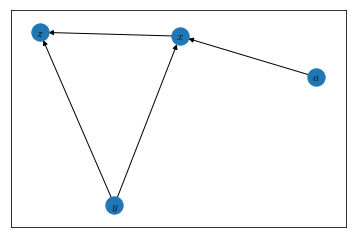

In [22]:
%matplotlib inline
import networkx as nx
nx.draw_networkx(p_all.graph.visible_graph())

Here is an example of graph visualization with external tools.

#### Requirements
- pygraphviz
- dot2tex
- pdflatex

In [ ]:
import os, shutil
from os.path import join as pjoin
import subprocess
from IPython.display import display_pdf
from networkx.drawing.nx_pydot import write_dot, to_pydot
import dot2tex as d2t

tmp_dir = 'tmp_distgraph'
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

%cd tmp_distgraph
dot_path = 'test.dot'
tex_path = 'test.tex'
pdf_path = 'test.pdf'
write_dot(p_all.graph.visible_graph(dotmode=True), dot_path)
with open(dot_path, 'r') as f:
    tex = d2t.dot2tex(f.read(), prog='dot', crop=True, autosize=True, texmode='math')#, usepdflatex=True)
with open(tex_path, 'w') as f:
    f.write(tex)
subprocess.run(['pdflatex', tex_path])

with open(pdf_path, "rb") as f:
    pdf_obj = display_pdf(f.read(),raw=True)

%cd ..

shutil.rmtree(tmp_dir)
pdf_obj

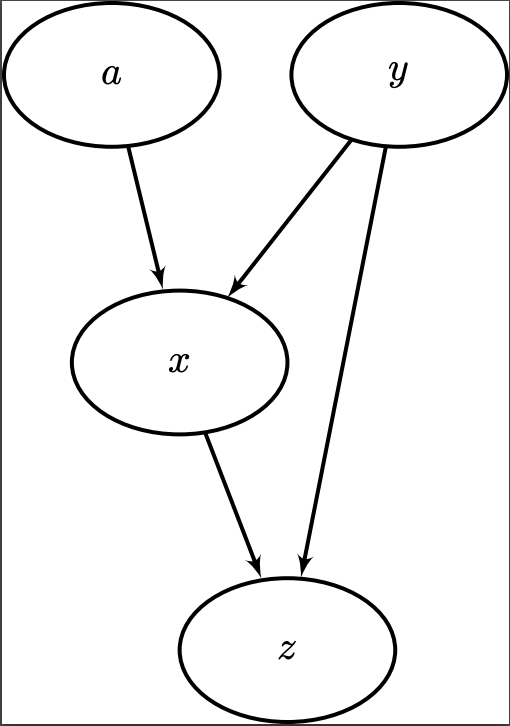